In [36]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings('ignore')

In [37]:
#os.system("kaggle competitions download -c blg454e-summer-2021")

In [38]:
sample_submission_loc = "blg454e-summer-2021/sampleSubmission.csv"
test_t0_loc = "blg454e-summer-2021/test_t0.csv"
train_t0_loc = "blg454e-summer-2021/train_t0.csv"
train_t1_loc = "blg454e-summer-2021/train_t1.csv"

In [39]:
test_t0_data = pd.read_csv(test_t0_loc)
train_t0_data = pd.read_csv(train_t0_loc)
train_t1_data = pd.read_csv(train_t1_loc)

In [40]:
def draw_scatter(data, x_range, y_range):
    fig, axs = plt.subplots(x_range, y_range)
        
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].scatter(range(len(data[data.columns[rand_temp]])), data[data.columns[rand_temp]], c=np.random.rand(len(data[data.columns[rand_temp]])))
            axs[i, j].set_title(rand_temp)
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [41]:
def draw_hist(data, x_range, y_range):
    
    fig, axs = plt.subplots(x_range, y_range)
    
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].hist(data[data.columns[rand_temp]])
            axs[i, j].set_title(rand_temp)
            
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

In [42]:
def draw_corr(data):
    plt.matshow(data.corr())
    plt.show()

In [43]:
def scatter_hist_helper(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
def scatter_hist(data, f_1, f_2):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    # use the previously defined function
    scatter_hist_helper(data[data.columns[f_1]], data[data.columns[f_2]], ax, ax_histx, ax_histy)
    
    plt.show()

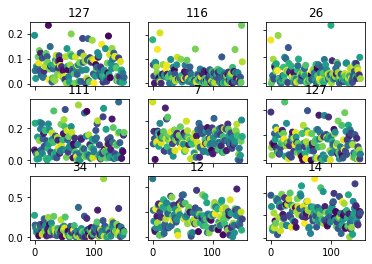

In [44]:
draw_scatter(train_t0_data, 3, 3)

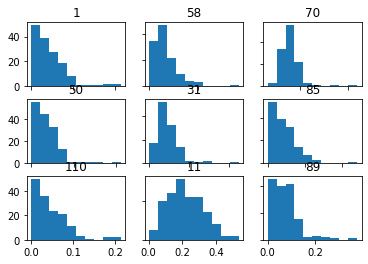

In [45]:
draw_hist(train_t0_data, 3, 3)

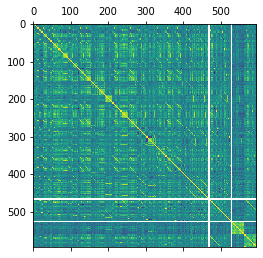

In [46]:
draw_corr(train_t0_data)

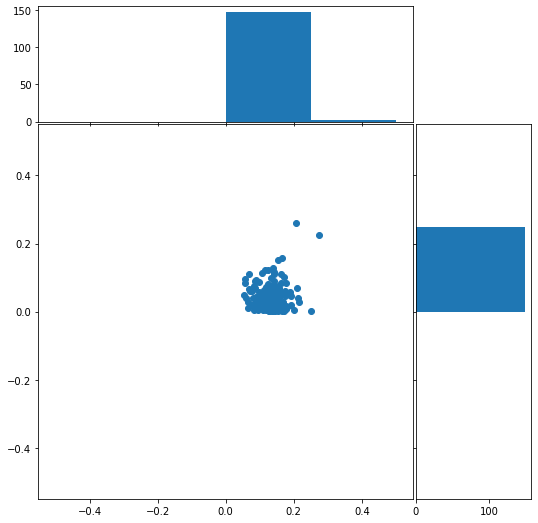

In [47]:
scatter_hist(train_t0_data, 10, 120)

In [48]:
def try_models(train,train_labels,test,test_labels, results):

    def test_model(model):

        model.fit(train, train_labels)
        test_predict = model.predict(test)
        actual = test_labels.flatten()
        predicted = test_predict.flatten()
        scores = mse(predicted, actual)

        return scores

    model = linear_model.LinearRegression()
    test_result = test_model(model)
    model_name = 'LinearRegression'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Ridge()
    test_result = test_model(model)
    model_name = 'Ridge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(SGDRegressor())
    test_result = test_model(model)
    model_name = 'SGDRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(linear_model.BayesianRidge())
    test_result = test_model(model)
    model_name = 'BayesianRidge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(linear_model.HuberRegressor())
    test_result = test_model(model)
    model_name = 'HuberRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Lasso(alpha=1e-4)
    test_result = test_model(model)
    model_name = 'Lasso'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
        
    model = BaggingRegressor()
    test_result = test_model(model)
    model_name = 'BaggingRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = ElasticNet()
    test_result = test_model(model)
    model_name = 'ElasticNet'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = RandomForestRegressor()
    test_result = test_model(model)
    model_name = 'RandomForestRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(AdaBoostRegressor())
    test_result = test_model(model)
    model_name = 'AdaBoostRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(svm.SVR(kernel="linear"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="linear")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
       
    model = MultiOutputRegressor(svm.SVR(kernel="rbf"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="rbf")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    return results

In [49]:
random.seed(1)
def cv(data, labels, n_fold, model=None, shuffle=False):
    kf = KFold(n_splits=n_fold, shuffle=shuffle)
    results = {}
    if model is not None:
        results['YourModel'] = []
    for train_index, test_index in kf.split(data):
        train = data[train_index, :]
        train_labels = labels[train_index, :]
        test = data[test_index, :]
        test_labels = labels[test_index, :]

        scaler = MinMaxScaler()
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        pca = PCA(0.70)
        pca.fit(train)
        train = pca.transform(train)
        test = pca.transform(test)

        if model == None:
            results = try_models(train,train_labels,test,test_labels, results)
        else:
            model.fit(train, train_labels)
            test_predict = model.predict(test)
            actual = test_labels.flatten()
            predicted = test_predict.flatten()
            scores = mse(predicted, actual)
            results['YourModel'].append(scores)

    results_df = pd.DataFrame(results).T
    variance = results_df.var(axis=1)
    mean = results_df.mean(axis=1)
    results_df.insert(5, "Var", variance)
    results_df.insert(6, "Mean", mean)  

    return results_df

In [50]:
def train_model_and_predict(model, data, labels, test):
    scaler = StandardScaler()
    scaler.fit(data)
    train = scaler.transform(data)

    pca = PCA(0.70)
    pca.fit(train)
    train = pca.transform(train)
    model.fit(train, labels)
    
    test_data = scaler.transform(test)
    test_data = pca.transform(test_data)
    prediction = model.predict(test_data)

    return model, prediction

<h2>TRAIN_T0 ANALYSIS<h2>

In [51]:
train_t0_data.head()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595
0,0,0.193382,0.096121,0.289502,0,0.193382,0.096121,0.273247,0.466629,0.177126,...,0.110908,0.193465,0.186630,0.174750,0.096996,0.242103,0.042979,0.015484,0.015484,0.048103
1,1,0.014410,0.064584,0.050174,0,0.014410,0.064584,0.115367,0.100957,0.050783,...,0.101471,0.028694,0.187073,0.111753,0.100301,0.089273,0.099579,0.013585,0.013585,0.243097
2,2,0.070879,0.077238,0.148117,0,0.070879,0.077238,0.162528,0.233407,0.085291,...,0.085059,0.160802,0.142508,0.114494,0.080725,0.054955,0.084518,0.046046,0.046046,0.126800
3,3,0.012150,0.053557,0.065708,0,0.012150,0.053557,0.135480,0.147630,0.081922,...,0.066011,0.034460,0.122039,0.094287,0.062342,0.067846,0.080307,0.007430,0.007430,0.218388
4,4,0.035510,0.072512,0.037002,0,0.035510,0.072512,0.056819,0.021309,0.015693,...,0.098395,0.117918,0.121873,0.096543,0.081662,0.109835,0.055561,0.017878,0.017878,0.232787


In [52]:
print(train_t0_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Columns: 596 entries, ID to f595
dtypes: float64(589), int64(7)
memory usage: 698.5 KB
None


In [18]:
train_t0_data.describe()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595
count,150.000000,150.000000,150.000000,150.000000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,74.500000,0.044582,0.080598,0.071282,0.0,0.044582,0.080598,0.131620,0.115131,0.061869,...,0.105047,0.100972,0.172020,0.136881,0.127180,0.121855,0.109727,0.029184,0.029184,0.240352
std,43.445368,0.037994,0.039930,0.050766,0.0,0.037994,0.039930,0.037942,0.064775,0.046194,...,0.041862,0.059288,0.056443,0.047358,0.045876,0.042679,0.042027,0.026718,0.026718,0.078478
min,0.000000,0.000089,0.001989,0.000940,0.0,0.000089,0.001989,0.054214,0.000020,0.000580,...,0.012323,0.005157,0.007663,0.011979,0.030873,0.003749,0.014510,0.000395,0.000395,0.042528
25%,37.250000,0.017879,0.056915,0.032421,0.0,0.017879,0.056915,0.108719,0.068408,0.024877,...,0.076577,0.054555,0.135979,0.102224,0.093079,0.089561,0.080658,0.010046,0.010046,0.194399
50%,74.500000,0.033523,0.076158,0.061955,0.0,0.033523,0.076158,0.130866,0.115870,0.056490,...,0.101955,0.091981,0.158843,0.132284,0.123985,0.120384,0.107655,0.020933,0.020933,0.244233
75%,111.750000,0.059201,0.100670,0.099729,0.0,0.059201,0.100670,0.155715,0.155132,0.085909,...,0.131724,0.135250,0.201340,0.164686,0.155491,0.150561,0.131991,0.041979,0.041979,0.301425
max,149.000000,0.214443,0.375598,0.289502,0.0,0.214443,0.375598,0.273247,0.466629,0.242402,...,0.218610,0.299961,0.414848,0.345963,0.346058,0.242103,0.262390,0.186477,0.186477,0.465477


<h3>Static Feature Dropping<h3>

In [19]:
train_t0_clean = train_t0_data.drop("ID", 1)
train_t1_clean = train_t1_data.drop("ID", 1)
test_t0_clean = test_t0_data.drop("ID", 1)

In [20]:
square_diff = np.square(train_t1_clean - train_t0_clean)
sum = np.sum(square_diff, axis=0)
locs = np.where(sum == 0)
print(locs)
train_t0_clean = train_t0_clean.drop(train_t0_clean.columns[locs], axis=1)
test_t0_clean = test_t0_clean.drop(train_t0_clean.columns[locs], axis=1)

(array([  3, 465, 468, 496, 499, 527], dtype=int64),)


<h3>Outlier Dropping With LocalOutlierFactor<h3>

In [21]:
ouitlier = LocalOutlierFactor(n_neighbors=10)
outlier_loc = ouitlier.fit_predict(train_t0_clean)

In [22]:
print(outlier_loc)
print(ouitlier.negative_outlier_factor_)

[-1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1]
[-3.42289914 -1.02062143 -1.15206255 -0.97926956 -0.98092035 -1.28299471
 -1.0827248  -1.05037801 -1.16172068 -1.05657391 -1.1043155  -1.00707242
 -2.73994394 -1.11961675 -1.32091517 -1.03096786 -1.21071416 -1.08594354
 -1.10632418 -1.0079519  -1.04686596 -1.1684517  -1.10336896 -1.71946358
 -1.00302701 -1.0098119  -1.00006089 -0.98371177 -1.13835555 -1.16611371
 -1.06979596 -1.06171117 -1.0247317  -0.99880361 -0.99479312 -0.99619912
 -1.30215637 -1.00826489 -0.9979253  -1.07720313 -1.3528812  -1.79022879
 -0.99668825 -1.01921833 -1.016

In [23]:
locs = np.where(outlier_loc < 0)
print(locs)

(array([  0,   5,  12,  14,  23,  36,  40,  41,  45,  65,  73, 115, 119,
       122, 148], dtype=int64),)


In [24]:
train_t0_clean = train_t0_clean.drop(train_t0_clean.index[locs], axis=0)
train_t1_clean = train_t1_clean.drop(train_t1_clean.index[locs], axis=0)

In [25]:
train_t0_clean.head()

,f1,f2,f3,f5,f6,f7,f8,f9,f10,f11,...,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595
1,0.014410,0.064584,0.050174,0.014410,0.064584,0.115367,0.100957,0.050783,0.115367,0.280751,...,0.101471,0.028694,0.187073,0.111753,0.100301,0.089273,0.099579,0.013585,0.013585,0.243097
2,0.070879,0.077238,0.148117,0.070879,0.077238,0.162528,0.233407,0.085291,0.162528,0.086521,...,0.085059,0.160802,0.142508,0.114494,0.080725,0.054955,0.084518,0.046046,0.046046,0.126800
3,0.012150,0.053557,0.065708,0.012150,0.053557,0.135480,0.147630,0.081922,0.135480,0.065623,...,0.066011,0.034460,0.122039,0.094287,0.062342,0.067846,0.080307,0.007430,0.007430,0.218388
4,0.035510,0.072512,0.037002,0.035510,0.072512,0.056819,0.021309,0.015693,0.056819,0.092735,...,0.098395,0.117918,0.121873,0.096543,0.081662,0.109835,0.055561,0.017878,0.017878,0.232787
6,0.178187,0.062111,0.116076,0.178187,0.062111,0.118773,0.059414,0.056661,0.118773,0.087465,...,0.096541,0.121464,0.158674,0.152097,0.067157,0.125985,0.127955,0.012430,0.012430,0.244700


<h3>Model Training And Choosing Best<h3>

In [26]:
X = train_t0_clean.to_numpy()
Y = train_t1_clean.to_numpy()

In [27]:
results = cv(X, Y, 5, shuffle=True)

In [28]:
results

,0,1,2,3,4,Var,Mean
LinearRegression,0.003221,0.004635,0.006969,0.002299,0.003247,0.000003,0.004074
Ridge,0.003199,0.004622,0.006966,0.002286,0.003236,0.000003,0.004062
SGDRegressor,0.003541,0.004919,0.007542,0.002536,0.003358,0.000004,0.004379
BayesianRidge,0.002730,0.004353,0.006959,0.002007,0.002978,0.000004,0.003805
HuberRegressor,0.002852,0.004553,0.006838,0.002093,0.002895,0.000004,0.003846
Lasso,0.003206,0.004625,0.006964,0.002287,0.003238,0.000003,0.004064
BaggingRegressor,0.003072,0.004698,0.007705,0.002347,0.004473,0.000004,0.004459
ElasticNet,0.002891,0.004846,0.007701,0.002388,0.003248,0.000005,0.004215
RandomForestRegressor,0.003065,0.004910,0.008030,0.003282,0.003986,0.000004,0.004655
AdaBoostRegressor,0.002751,0.004577,0.007286,0.002140,0.002983,0.000004,0.003948


In [29]:
clf = MultiOutputRegressor(linear_model.BayesianRidge())

clf, prediction = train_model_and_predict(clf, X, Y, test_t0_clean.to_numpy())

In [30]:
prediction

array([[0.03290719, 0.08244805, 0.10364412, ..., 0.04396846, 0.04396846,
        0.2541584 ],
       [0.04777317, 0.07173937, 0.07062832, ..., 0.03032449, 0.03032449,
        0.19996652],
       [0.04864815, 0.07338444, 0.06675889, ..., 0.0519407 , 0.0519407 ,
        0.29323214],
       ...,
       [0.04765623, 0.08140619, 0.08413695, ..., 0.03777035, 0.03777035,
        0.21126831],
       [0.05607707, 0.09596062, 0.07388743, ..., 0.03841523, 0.03841523,
        0.25035662],
       [0.03561804, 0.07502674, 0.07925177, ..., 0.03654202, 0.03654202,
        0.29776649]])

In [32]:
def make_submission(prediction, filename):
    assert type(prediction) == np.ndarray, "Pass a numpy.ndarray"
    assert prediction.shape[0] == 80, f"Missing data points Expected 80 Got {prediction.shape[0]}"
    assert prediction.shape[1] == 595, f"Number of features predicted is not correct Excpected 595 Got {prediction.shape[1]}"
    assert type(filename) == str, "Filename must be a string"
    assert '.csv' in filename, "Add extension '.csv'"
    
    df = pd.DataFrame(prediction.flatten())
    df.index.name = "ID"
    df = df.rename(columns={0:"predicted"})
    df.to_csv(filename)
    print(f"{filename} saved at {os.getcwd()}")
    return df

In [33]:
make_submission(prediction, "BayesianRidgeV0.3.csv")

BayesianRidgeV0.2.csv saved at C:\Users\Syber-Viper\Desktop\ITU\LfD\Term Project


,predicted
ID,
0,0.032907
1,0.082448
2,0.103644
3,0.000000
4,0.032907
5,0.082448
6,0.136675
7,0.160413
8,0.069511


<h2>Metrics<h2>

In [59]:
scaler = StandardScaler()
scaler.fit(X)
train = scaler.transform(X)

pca = PCA(0.70)
pca.fit(train)
train = pca.transform(train)
clf.fit(train, Y)

prediction = clf.predict(train)

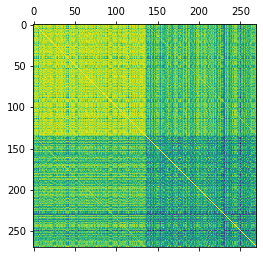

In [60]:
rho = np.corrcoef(prediction, Y)
plt.matshow(rho)